In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [3]:
def funciones(xi,y, sigma, n, h):
    psi_, eta_, psi1_, eta1_ = y
    dydxi = [h*(eta_ + sigma*xi**(3)*psi_**(n+1))*(1 + sigma*psi_)/xi/(2*(n+1)*sigma*eta_ - xi) 
           ,xi**(2)*psi_**(n) 
           ,h*(((eta1_ + 3*sigma*xi**(2)*psi_**(n+1) + sigma*xi**(3)*(n+1)*psi_**(n)*psi1_)*(sigma*psi_ + 1)/xi/(2*(n+1)*sigma*eta_ - xi)) + (sigma*psi1_*(eta_ + sigma*xi**(3)*psi_**(n+1))/xi/(2*(n+1)*sigma*eta_ - xi)) - ((1 + sigma*psi_)*(eta_ + sigma*xi**(3)*psi_**(n+1))/xi**(2)/(2*(n+1)*sigma*eta_ - xi)) - ((1 + sigma*psi_)*(eta_ + sigma*xi**(3)*psi_**(n+1))*(2*(n+1)*sigma*eta1_ - 1)/xi/((2*(n+1)*sigma*eta_ - xi)**(2))))           
           ,2*xi*psi_**(n) + xi**(2)*n*psi_**(n-1)*psi1_]
    return dydxi

In [4]:
c = 2.997*10**(8)          # Velocidad de la luz en S.I.
G = 6.673*10**(-11)        # Constante de gravitación universal en S.I.
Msun = 1.989*10**(30)      # Masa solar en S.I.

In [5]:
C = 1/8                  # Valor de C para anisotropía

h = 1 - 2*C

n = 1.5

rho_c = 1.5*10**(18)

Lista_sigma = [0.1,0.2,0.3,0.4,0.5,0.6]

print('\u03c3 interval: ',end='')
print(*Lista_sigma, sep=', ')

σ interval: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6


In [6]:
ListaModelos = []

In [7]:
%%time

for i in range(len(Lista_sigma)):
    
    sigma = Lista_sigma[i]
    
    # Condiciones iniciales
    Psi0 = 1.0
    Eta0 = 0.0
    Psi10 = 0.0
    Eta10 = 0.0
    
    y0 = [Psi0,Eta0,Psi10,Eta10]
    
    def stop_condition(xi,y,sigma,n,h):
        return y[0] - 10**-15
    
    stop_condition.terminal = True
    
    xi0 = 10**(-15)
    ximax = 10000
    
    xi_span = (xi0,ximax)
   
    
    soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                           args=(sigma,n,h),dense_output=True,max_step=1/50)
    
    Psi = soluciones.y[0]
    Eta = soluciones.y[1]
    Psi1 = soluciones.y[2]
    Eta1 = soluciones.y[3]
    xi = soluciones.t    
        
#############################################################################################################################    
        
    # Xi normalizada
    xiNorm = xi/xi[-1]
        
    Densidad = Psi**(n)
    
    Dprima = n*Psi**(n-1)*Psi1                               # Density gradient
    
    PNorm = Psi**(n+1)
    
    m = (c**(2)*sigma*(n+1)/(4*np.pi*rho_c)**(1/3)/G)**(3/2)*Eta/Msun   # Masa en unidades de masa solar
    r = (c**(2)*sigma*(n+1)/4/np.pi/G/rho_c)**(1/2)*xi/1000             # Radio en kilómetros
    mr = 2*sigma*(n+1)*Eta/xi                                           # 2*G*m/c**(2)/r
    
    # Presión tangencial
    PTNorm = (C*(n+1)*(Eta + sigma*Psi**(n+1)*xi**(3))/(xi - 2*Eta*sigma*(n+1)))*(Psi**(n) + sigma*Psi**(n+1)) + Psi**(n+1)
    
    mrprima = sigma*(n+1)*(Eta1/xi - Eta/xi**(2))   # Derivada de m/r
    
    # Gradiente de presión radial
    Pprima = (n+1)*Psi**(n)*Psi1
    
    # Gradiente de presión tangencial
    Ptprima = C*(n+1)*((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*(n+1)*xi**(3)*Psi**(n)*Psi1)*(Psi**(n) + sigma*Psi**(n+1))/(xi - 2*Eta*(n+1)*sigma) + (Eta + sigma*xi**(3)*Psi**(n+1))*(n*Psi**(n-1)*Psi1 + sigma*(n+1)*Psi**(n)*Psi1)/(xi - 2*Eta*(n+1)*sigma) - (Eta + sigma*xi**(3)*Psi**(n+1))*(Psi**(n) + sigma*Psi**(n+1))*(1 - 2*Eta1*(n+1)*sigma)/(xi - 2*Eta*(n+1)*sigma)**(2)) + (n+1)*Psi**(n)*Psi1
    
    SEC = (1/sigma)*Densidad - PNorm - 2*PTNorm 
    
    # Diferencia de las velocidades del sonido al cuadrado
    vDelta2 = (C*sigma*(n+1)/(xi-2*sigma*(n+1)*Eta))*((1+sigma*(n+1)*Psi/n)*(Eta+sigma*xi**(3)*Psi**(n+1)) + (1+sigma*Psi)*xi**(2)*Psi**(n+1)*((1+3*sigma*Psi)/Psi1 + sigma*(n+1)*xi)/n - (1+sigma*Psi)*Psi*(Eta+sigma*xi**(3)*Psi**(n+1))*(1-2*sigma*(n+1)*xi**(2)*Psi**(n))/n/Psi1/(xi-2*sigma*(n+1)*Eta))
    
    # Velocidad del sonido radial al cuadrado
    v2r = sigma*(1 + 1/n)*Psi
    
    # Velocidad del sonido tangencial al cuadrado
    v2t = vDelta2 + v2r
    
    Gamma = v2r*(Densidad + sigma*PNorm)/PNorm/sigma

    # Segunda derivada de Psi
    Psi11 = h*(((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*xi**(3)*(n+1)*Psi**(n)*Psi1)*(sigma*Psi + 1)/xi/(2*(n+1)*sigma*Eta - xi)) + (sigma*Psi1*(Eta + sigma*xi**(3)*Psi**(n+1))/xi/(2*(n+1)*sigma*Eta - xi)) - ((1 + sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi**(2)/(2*(n+1)*sigma*Eta - xi)) - ((1 + sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))*(2*(n+1)*sigma*Eta1 - 1)/xi/((2*(n+1)*sigma*Eta - xi)**(2))))
    
    # Fracturas: deltaR1: Densidad, deltaR2: Masa, deltaR3: Presión, delta R4: Gradiente de presión   
    deltaR1 = h*((n+1) * sigma * (Eta + xi**(3) * sigma * Psi**(n+1)) / xi / (xi - 2 * sigma * n * Eta - 2 * sigma * Eta))
    deltaR2 = h*(Psi**(n+1) * xi**(2) * sigma * (n+1) * (1 + sigma * Psi) * (1 + 2 * xi**(2) * sigma * sigma * (n+1) * Psi**(n+1)) / n / Psi1 / ((xi - 2 * Eta * sigma * n - 2 * Eta * sigma)**(2)))
    deltaR3 = h*(sigma * (n+1)**(2) * sigma * Psi * (Eta + xi**(3) * Psi**(n) + 2 * sigma * xi**(3) * Psi**(n+1)) / n / xi / (xi - 2 * sigma * n * Eta - 2 * sigma * Eta))
    deltaR4 = sigma * (n+1) * (n * Psi1**(2) + Psi * Psi11) / n / Psi1
    
    deltaRPolitropa = deltaR1 + deltaR2 + deltaR3 + deltaR4
    
    # Flotabilidad
    Psin11 = n*(Psi**(n-1)*Psi11 + (n-1)*Psi**(n-2)*Psi1**(2))
        
#     R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(k/c**(2))**(n/2)*sigma**((1-n)/2)*xi[-1]/1000         # Radio en kilómetros
    
#     M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(k/c**(2))**(n/2)*sigma**((3-n)/2)*Eta[-1]/Msun  # Masa en unidades de masa solar


                           #0    #1     #2       #3     #4      #5      #6      #7             
    ListaModelos.append([xiNorm, mr, Densidad, PNorm, PTNorm, Dprima, Pprima, Ptprima,
                                        #8  #9   #10   #11          #12         #13
                                       SEC, v2r, v2t, Gamma, deltaRPolitropa, Psin11])
    

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in subtract
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero 

Wall time: 305 ms


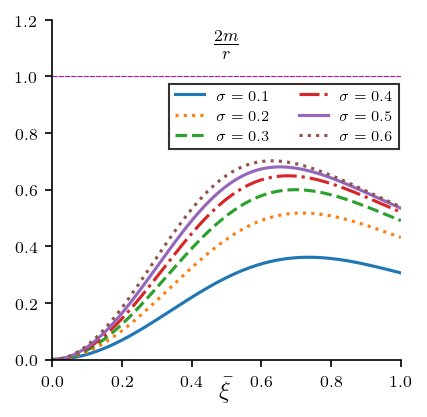

In [8]:
LineStyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot','solid', 'dotted', 'dashed', 'dashdot']

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][1],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.2)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{2m}{r}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=2, loc=(0.335,0.62),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

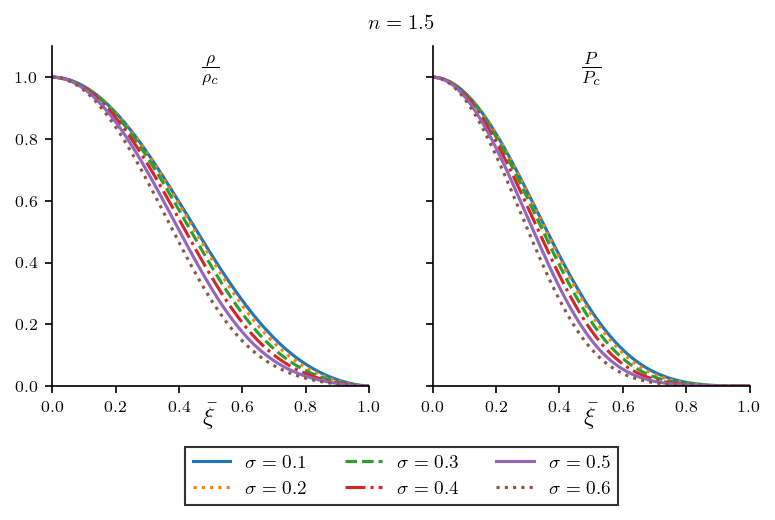

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3),dpi=150)
fig.suptitle(r'$n = {}$'.format(n),x=0.5125,y=0.95,fontsize=10)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][2],linestyle=LineStyles[i],label=r'$\sigma = {}$'.format(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][3],linestyle=LineStyles[i],label=r'$\sigma = {}$'.format(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.1)
ax2.set_xbound(0.0,1.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\rho}{\rho_{c}}$', x=0.5,y=0.85,fontsize=12)
ax2.set_title(r'$\frac{P}{P_{c}}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=3, loc=(0.42,-0.35),fontsize=9,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

plt.show()

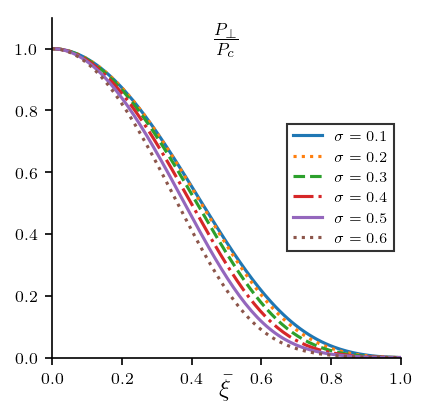

In [10]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][4],linestyle=LineStyles[i],label=r'$\sigma = {}$'.format(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.1)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{P_{\perp}}{P_c}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=1, loc=5,fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

plt.show()

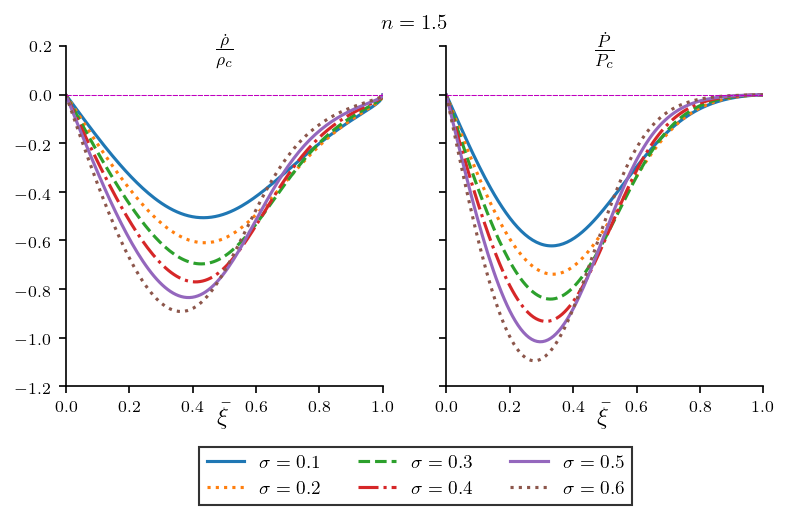

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3),dpi=150)
fig.suptitle(r'$n = {}$'.format(n),x=0.5125,y=0.95,fontsize=10)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][5],linestyle=LineStyles[i],label=r'$\sigma = {}$'.format(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][6],linestyle=LineStyles[i],label=r'$\sigma = {}$'.format(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.2,0.2)
ax2.set_xbound(0.0,1.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\dot{\rho}}{\rho_{c}}$', x=0.5,y=0.9,fontsize=12)
ax2.set_title(r'$\frac{\dot{P}}{P_{c}}$', x=0.5,y=0.9,fontsize=12)
ax1.legend(ncol=3, loc=(0.42,-0.35),fontsize=9,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.axhline(y=0.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
ax2.axhline(y=0.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()



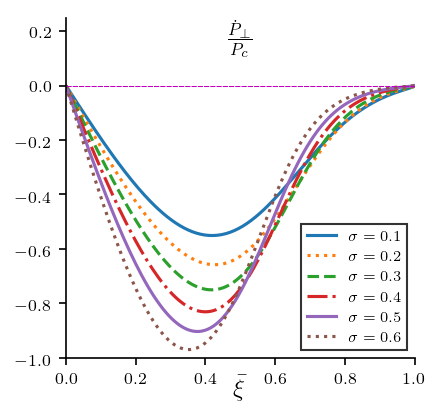

In [12]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][7],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.0,0.25)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\dot{P}_{\perp}}{P_{c}}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=1, loc=4,fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

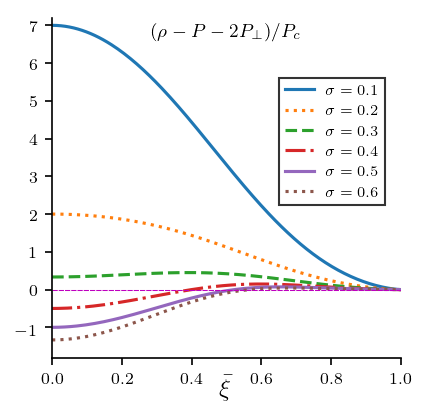

In [13]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][8],
             linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.8,7.2)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$(\rho - P - 2P_{\perp})/P_{c}$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=1, loc=(0.65,0.45),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

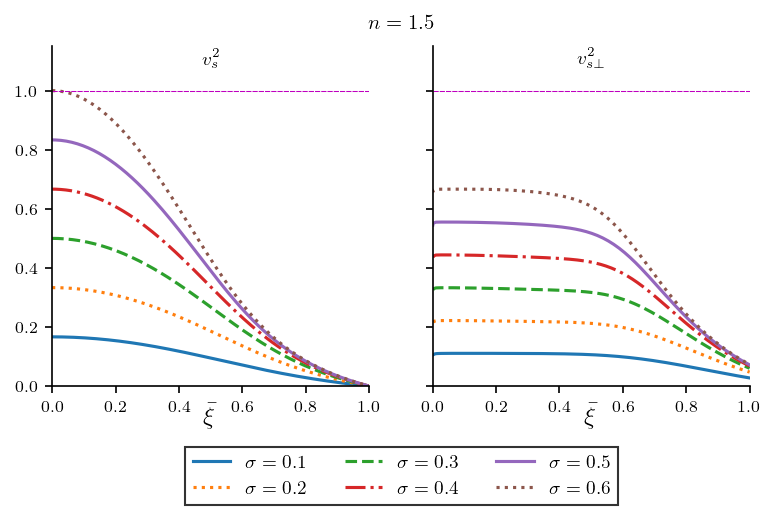

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3),dpi=150)
fig.suptitle(r'$n = 1.5$',x=0.5125,y=0.95,fontsize=10)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][9],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][10],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.15)
ax2.set_xbound(0.0,1.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$v^{2}_{s}$', x=0.5,y=0.9,fontsize=9)
ax2.set_title(r'$v^{2}_{s \perp}$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=3, loc=(0.42,-0.35),fontsize=9,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
ax2.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

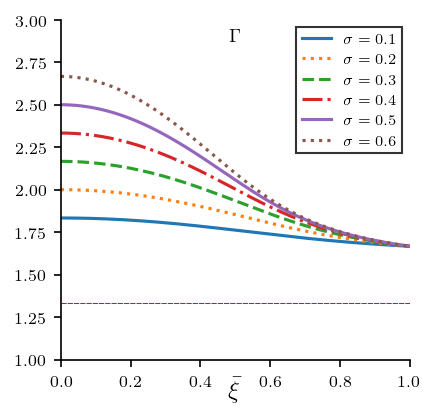

In [15]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][11],
             linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(1.0,3.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\Gamma$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=1, loc=1,fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=4/3,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

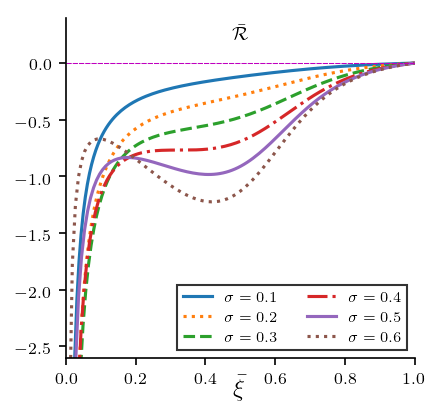

In [16]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][12],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-2.6,0.4)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\bar{\mathcal{R}}$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=2, loc=4,fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

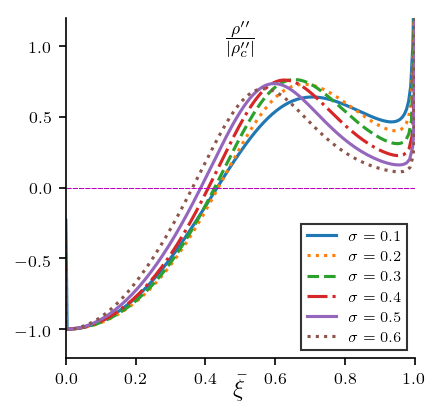

In [17]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][13]/abs(ListaModelos[i][13][1]),linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.2,1.2)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\rho^{\prime \prime}}{|\rho^{\prime \prime}_{c}|}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=1, loc=4,fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()